In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using MCMCDiagnostics

In [2]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [3]:
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
@load "../data/sim2data.jld";

In [5]:
# priors #
ϕU = 300 / sqrt(2); ϕL = 3 / sqrt(2);

In [6]:
x_1 = X_ord[S1_ind, :]; x_2 = X_ord[S2_ind, :]; 
y_1 = Y_ord[S1_ind, 1]; y_2 = Y_ord[S2_ind, 2]; 
coords_1 = coords_ord[S1_ind, :]; coords_2 = coords_ord[S2_ind, :]; 
P1_ind = setdiff(1:N, S1_ind);
P2_ind = setdiff(1:N, S2_ind);
coords_ord_P1 = coords_ord[P1_ind, :];
coords_ord_P2 = coords_ord[P2_ind, :];

In [7]:
using RCall
@rput x_1 x_2 y_1 y_2 X_ord;
@rput q p K;
@rput ϕU ϕL;
@rput coords_1 coords_2 coords_ord_P1 coords_ord_P2 P1_ind P2_ind


R"""
library(spBayes)
set.seed(1)
n.samples <- 10000
A.starting <- diag(1, q)[lower.tri(diag(1,q), TRUE)]
starting <- list("phi"=rep(3/0.5,q), "A"=A.starting, "Psi"=rep(1,q))
tuning <- list("phi"=rep(0.1,q), "A"=rep(0.01,length(A.starting)), "Psi"=rep(0.01,q))
priors <- list("beta.Flat", "phi.Unif"=list(rep(ϕL, q), rep(ϕU, q)),
               "K.IW"=list(q + 1, diag(1.0, q)), "Psi.ig"=list(rep(2 , q), rep(0.5, q)))
t <- proc.time()
m.1 <- spMisalignLM(list(y_1~x_1-1, y_2~x_2-1), 
                    coords = list(coords_1, coords_2), starting=starting, tuning=tuning, priors=priors,
                    n.samples=n.samples, cov.model="exponential", n.report=100)
burn.in <- 0.5*n.samples

m.1 <- spRecover(m.1, start = burn.in)

print(proc.time()-t)

print(round(summary(m.1$p.theta.recover.samples)$quantiles[,c(3,1,5)],2))
print(round(summary(m.1$p.beta.recover.samples)$quantiles[,c(3,1,5)],2))
theta_samples_all <- m.1$p.theta.samples
theta_samples <- m.1$p.theta.recover.samples
beta_samples <- m.1$p.beta.recover.samples
w_samples <- m.1$p.w.recover.samples
cat(m.1$run.time)

t <- proc.time()
# predict for all locations, i.e., observed and not observed
out <- spPredict(m.1, start = burn.in, thin = 1, pred.covars = list(X_ord[P1_ind, ], X_ord[P2_ind, ]),
                pred.coords = list(coords_ord_P1, coords_ord_P2))
cat("\n", proc.time() - t)
mean_quants <- function(x){c(mean(x), quantile(x, prob=c(0.5, 0.025, 0.975)))}
yhat <- apply(out$p.y.predictive.samples, 1, mean_quants)
m1_w_hat <- summary(mcmc(t(m.1$p.w.recover.samples)))$quantiles[,c(3,1,5)]


# size for the mapping of w               
width <- 360*3
height <- 360*3
pointsize <- 16

png(paste("../../pics/MCMC_sim4_spBayes.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
plot(m.1$p.theta.samples)
dev.off()

"""
@rget theta_samples_all
@rget theta_samples
@rget beta_samples
@rget yhat
@rget m1_w_hat
@rget w_samples

┌ Warning: RCall.jl: Loading required package: coda
│ Loading required package: magic
│ Loading required package: abind
│ Loading required package: Formula
│ Loading required package: Matrix
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113


----------------------------------------
	General model description
----------------------------------------
Model fit with 2 outcome variables.

Number of observations within each outcome: 1000 1000 

Number of covariates for each outcome (including intercept if specified): 2 2 

Total number of observations: 2000

Total number of covariates (including intercept if specified): 4

Using the exponential spatial correlation model.

Number of MCMC samples 10000.

Priors and hyperpriors:
	beta flat.

	K IW hyperpriors df=3.00000, S=
	1.000	0.000	
	0.000	1.000	

	Diag(Psi) IG hyperpriors
		parameter	shape	scale
		Psi[1,1]	2.0	0.50
		Psi[2,2]	2.0	0.50

	phi Unif hyperpriors
		parameter	a	b
		phi[1]		2.12132	212.13203
		phi[2]		2.12132	212.13203

-------------------------------------------------
		Sampling
-------------------------------------------------
Sampled: 100 of 10000, 1.00%
Report interval Metrop. Acceptance rate: 32.00%
Overall Metrop. Acceptance rate: 32.00%
----------------------

Sampled: 4500 of 10000, 45.00%
Report interval Metrop. Acceptance rate: 3.00%
Overall Metrop. Acceptance rate: 6.16%
-------------------------------------------------
Sampled: 4600 of 10000, 46.00%
Report interval Metrop. Acceptance rate: 5.00%
Overall Metrop. Acceptance rate: 6.13%
-------------------------------------------------
Sampled: 4700 of 10000, 47.00%
Report interval Metrop. Acceptance rate: 5.00%
Overall Metrop. Acceptance rate: 6.11%
-------------------------------------------------
Sampled: 4800 of 10000, 48.00%
Report interval Metrop. Acceptance rate: 5.00%
Overall Metrop. Acceptance rate: 6.08%
-------------------------------------------------
Sampled: 4900 of 10000, 49.00%
Report interval Metrop. Acceptance rate: 5.00%
Overall Metrop. Acceptance rate: 6.06%
-------------------------------------------------
Sampled: 5000 of 10000, 50.00%
Report interval Metrop. Acceptance rate: 9.00%
Overall Metrop. Acceptance rate: 6.12%
------------------------------------------------

Sampled: 9500 of 10000, 95.00%
Report interval Metrop. Acceptance rate: 8.00%
Overall Metrop. Acceptance rate: 6.21%
-------------------------------------------------
Sampled: 9600 of 10000, 96.00%
Report interval Metrop. Acceptance rate: 3.00%
Overall Metrop. Acceptance rate: 6.18%
-------------------------------------------------
Sampled: 9700 of 10000, 97.00%
Report interval Metrop. Acceptance rate: 6.00%
Overall Metrop. Acceptance rate: 6.18%
-------------------------------------------------
Sampled: 9800 of 10000, 98.00%
Report interval Metrop. Acceptance rate: 1.00%
Overall Metrop. Acceptance rate: 6.12%
-------------------------------------------------
Sampled: 9900 of 10000, 99.00%
Report interval Metrop. Acceptance rate: 1.00%
Overall Metrop. Acceptance rate: 6.07%
-------------------------------------------------
Sampled: 10000 of 10000, 100.00%
Report interval Metrop. Acceptance rate: 1.00%
Overall Metrop. Acceptance rate: 6.02%
----------------------------------------------

2000×5001 Array{Float64,2}:
 -0.31467     0.0529861  -0.936776   …  -0.439468    -0.295542   -0.475197 
  1.66843     1.87602     1.59402        1.8431       1.87167     2.00541  
 -0.0156672  -0.313297   -0.611564       0.129989    -0.697207   -0.758687 
 -1.31076    -0.879229   -1.55367       -1.26794     -0.855793   -1.27057  
 -1.07289    -0.161085   -0.922223      -1.13848     -0.3728     -1.00051  
 -1.5459     -1.27615    -2.22356    …  -1.42282     -1.03329    -2.16638  
  0.317538   -0.27675    -0.271772       0.298304    -0.258375    0.277961 
  0.296521    0.859642    0.415938       0.947178     1.15516     0.762405 
  0.0538167   0.365166    0.34272        0.146026     0.163286    1.12407  
  0.500483   -0.138663   -0.804796       0.198337    -0.0456355   0.179404 
  0.341572    0.481157   -0.0500962  …   0.497188     0.318736    0.571288 
  0.53727    -0.332194   -0.0490436      0.138427    -0.117463    0.566344 
 -0.705998   -0.904713   -1.10286        0.00255797  -1.0467

In [8]:
ω_incp_samples = Array{Float64, 2}(undef, size(w_samples));
N_sam = size(w_samples)[2]
for i in 1:N_sam
    for j in 1:q
        ω_incp_samples[(1 + (j - 1) * N1):(j * N1), i] = 
        w_samples[(1 + (j - 1) * N1):(j * N1), i] .+ beta_samples[i, 1 + (j - 1) * q]
    end
end

ω_incp_qt = Array{Float64, 3}(undef, N1, q, 3);
for j in 1:q
    for i in 1:N1
        ω_incp_qt[i, j, :] = quantile(ω_incp_samples[i + (j - 1) * N1, :], [0.025, 0.5, 0.975])
    end
end
ω_incp_mean = Array{Float64, 2}(undef, N1, q);
for j in 1:q
    for i in 1:N1
        ω_incp_mean[i, j] = mean(ω_incp_samples[i + (j - 1) * N1, :])
    end
end

In [9]:
@save "../results/LMC_misalign_spbayes.jld" theta_samples beta_samples yhat ω_incp_samples w_samples ω_incp_qt theta_samples_all

In [10]:
@save "../results/w_incp_mean_benchmark.jld" ω_incp_mean 

# MCMC Chain check

In [7]:
@load "../results/LMC_misalign_spbayes.jld"

7-element Array{Symbol,1}:
 :theta_samples    
 :beta_samples     
 :yhat             
 :ω_incp_samples   
 :w_samples        
 :ω_incp_qt        
 :theta_samples_all

In [8]:
@load "../results/w_incp_mean_benchmark.jld"

1-element Array{Symbol,1}:
 :ω_incp_mean

In [9]:
N_sam = size(w_samples)[2]
ω_qt = Array{Float64, 3}(undef, N1, q, 3);
for j in 1:q
    for i in 1:N1
        ω_qt[i, j, :] = quantile(w_samples[i + (j - 1) * N1, :], [0.025, 0.5, 0.975])
    end
end
ω_mean = Array{Float64, 2}(undef, N1, q);
for j in 1:q
    for i in 1:N1
        ω_mean[i, j] = mean(w_samples[i + (j - 1) * N1, :])
    end
end

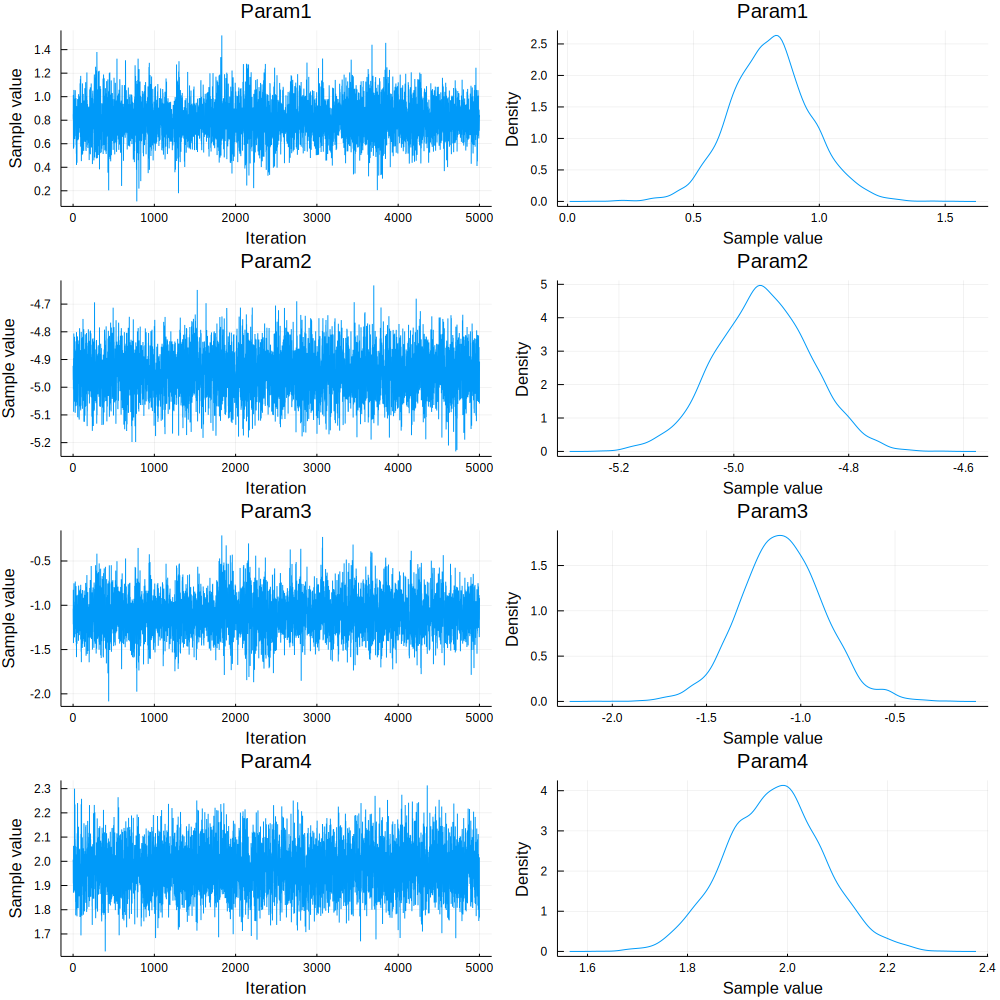

In [10]:
β_pos_sam = Array{Float64, 3}(undef, size(beta_samples)[1], p * q, 1);
β_pos_sam[:, :, 1] = hcat(beta_samples[:, 1], beta_samples[:, 2], beta_samples[:, 3], beta_samples[:, 4]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

In [11]:
β

2×2 Array{Float64,2}:
  1.0  -1.0
 -5.0   2.0

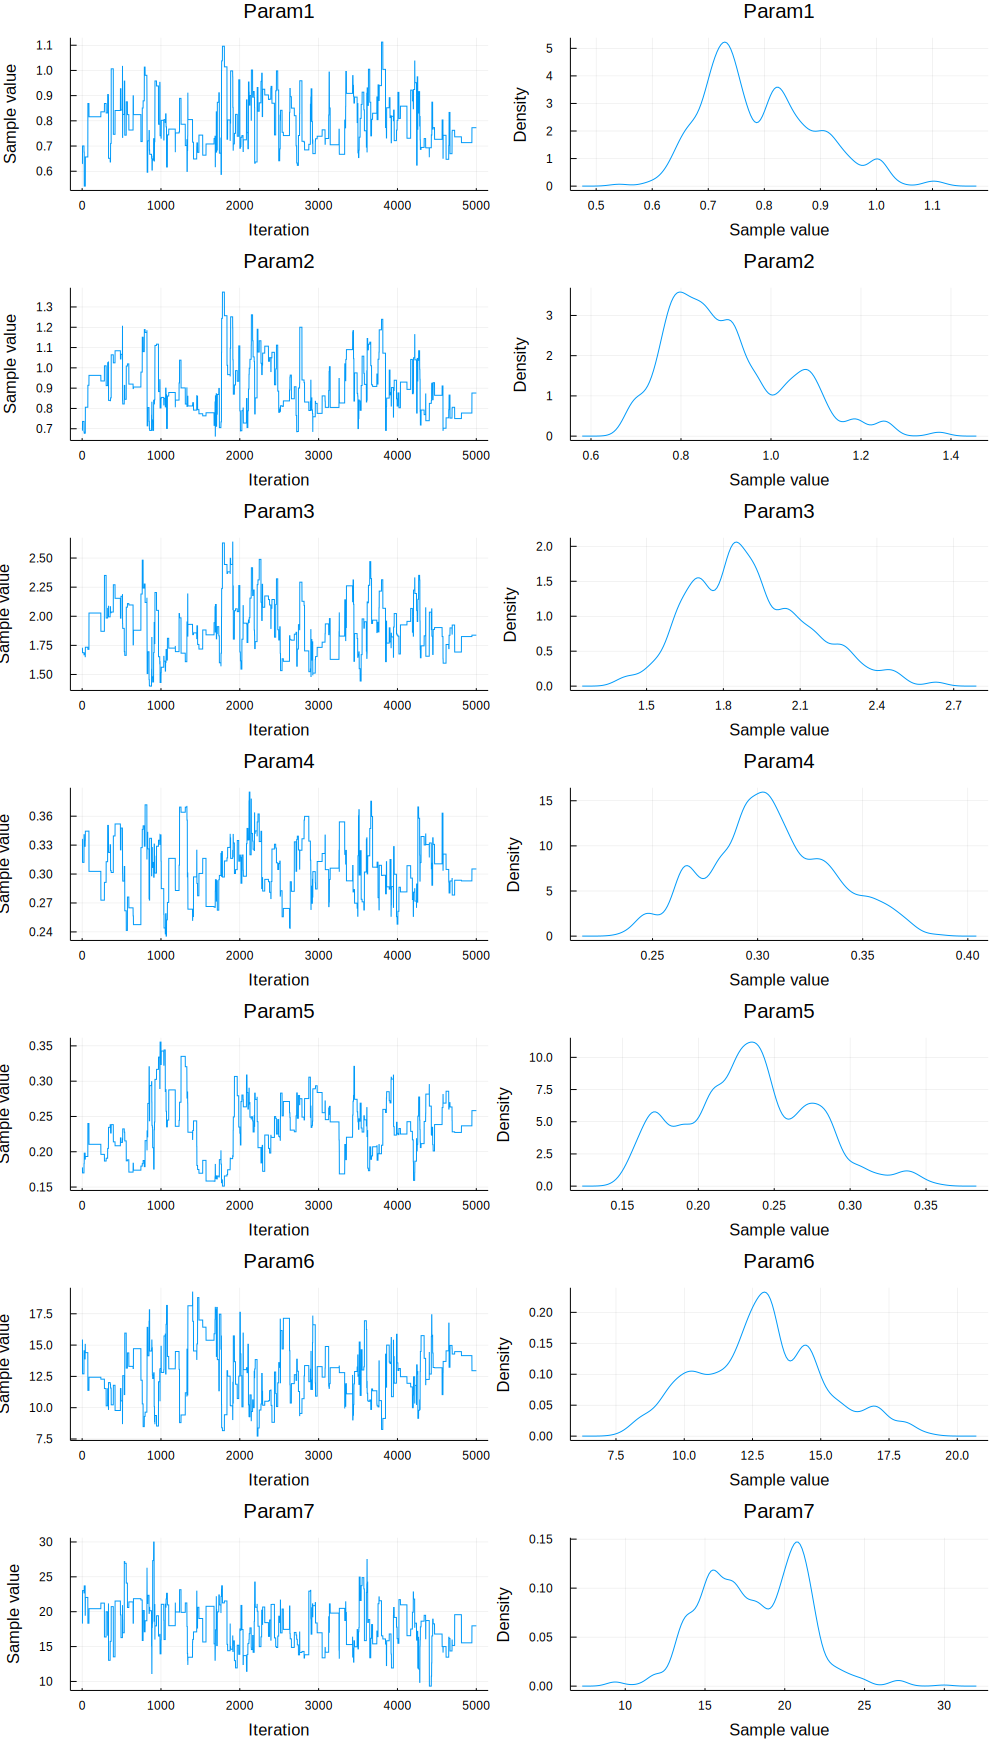

In [12]:
Λ_pos_sam = Array{Float64, 3}(undef, size(theta_samples)[1], size(theta_samples)[2], 1);
Λ_pos_sam[:, :, 1] = hcat(theta_samples[:, 1], theta_samples[:, 2], theta_samples[:, 3], theta_samples[:, 4],
    theta_samples[:, 5], theta_samples[:, 6], theta_samples[:, 7]);
Λ_chain = Chains(Λ_pos_sam);
pΛ = plot(Λ_chain)

In [13]:
Λ

2×2 Array{Float64,2}:
 1.0  1.0
 0.0  1.0

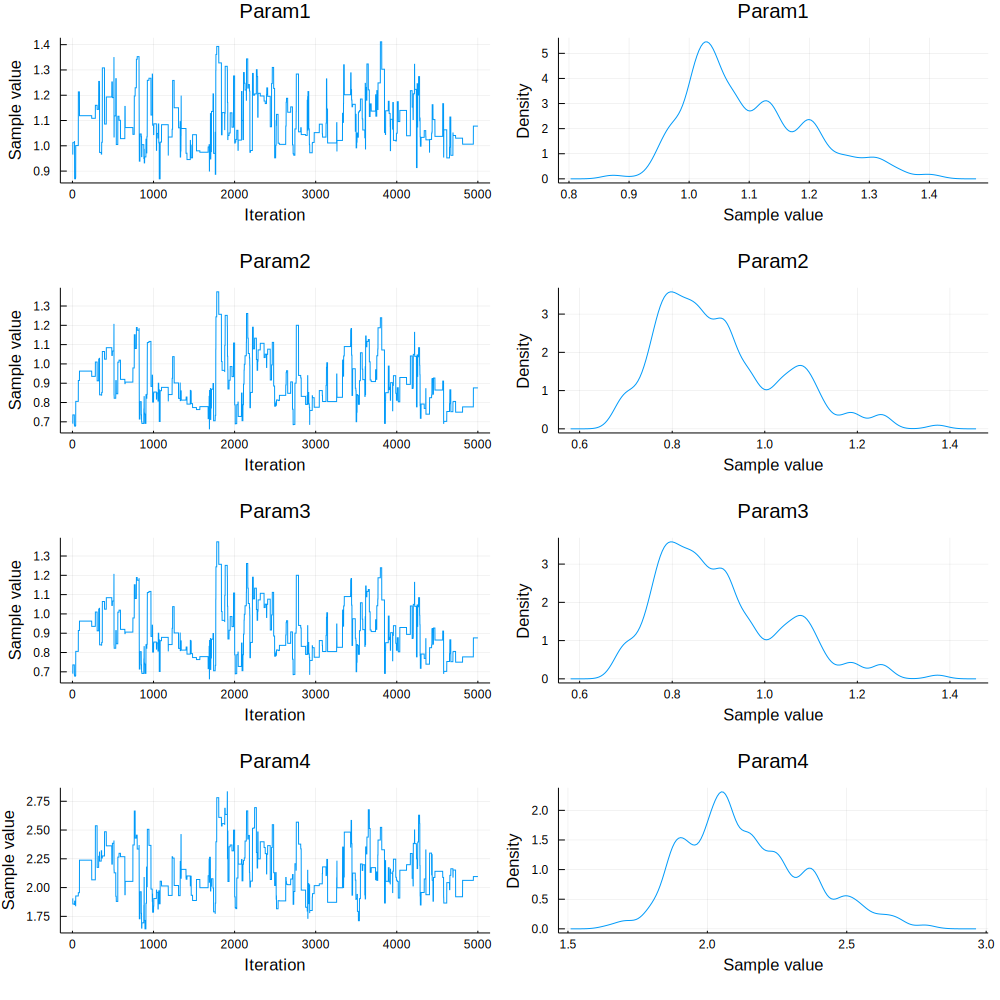

In [14]:
Ω_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
for i in 1:(N_sam)
    ΛTΛ_temp = [theta_samples[i, 1] theta_samples[i, 2]
        theta_samples[i, 2] theta_samples[i, 3]]
    Ω_pos_sam[i, :, 1] = vec(ΛTΛ_temp)
    Ω_pos_sam[i, 1, 1] = Ω_pos_sam[i, 1, 1] + theta_samples[i, 4];
    Ω_pos_sam[i, 4, 1] = Ω_pos_sam[i, 4, 1] + theta_samples[i, 5];
end
Ω_chain = Chains(Ω_pos_sam)
pΩ = plot(Ω_chain)

In [15]:
Ω = Λ'Λ +Σ

2×2 Array{Float64,2}:
 1.4   1.15
 1.15  2.3 

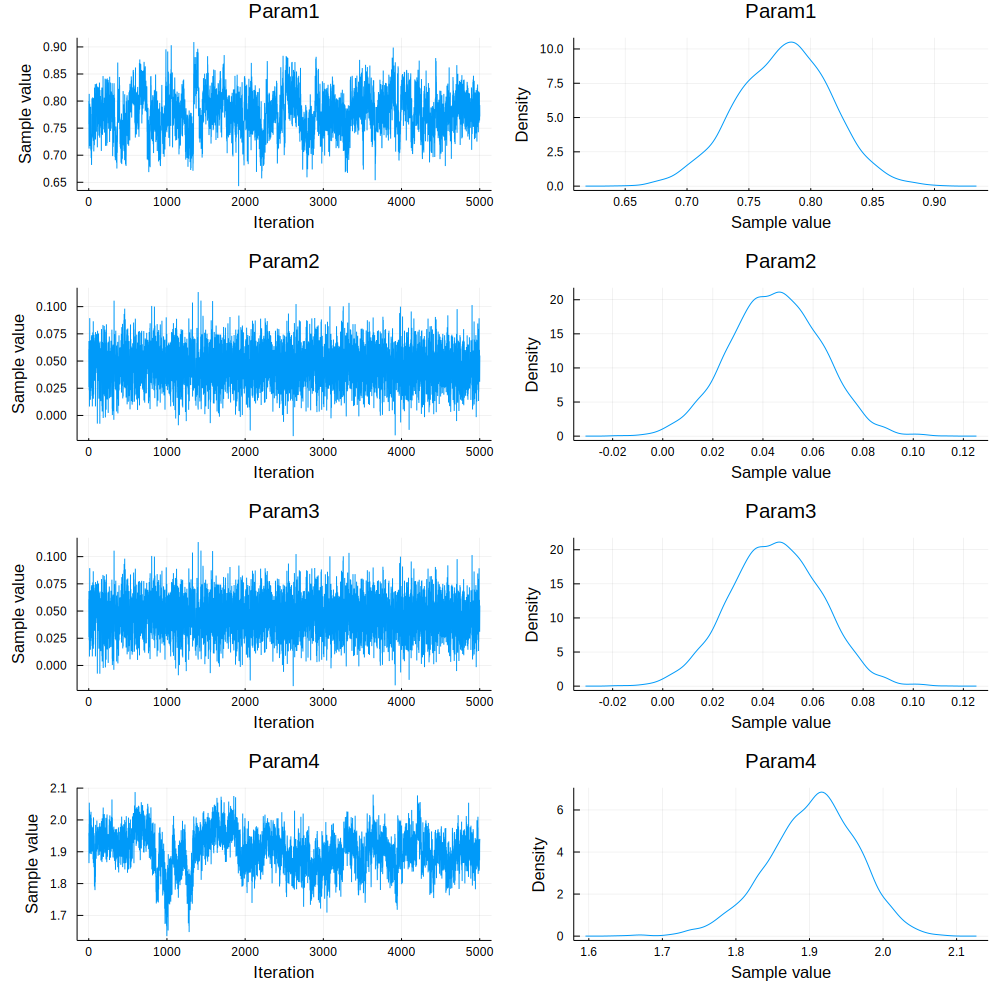

In [16]:
# check the variance covariance across latent process
N_sam = size(w_samples)[2]
cov_pos = Array{Float64, 3}(undef, q, q, N_sam);
for i in 1:N_sam
    cov_pos[:, :, i] = cov([w_samples[1:N1, i] w_samples[(1 + N1):(2 * N1), i]])
end   
# ω_incp_obs_pos_sam[:, :, i]
cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
cov_pos_sam[:, :, 1] = hcat(cov_pos[1, 1, :], cov_pos[1, 2, :], 
    cov_pos[2, 1, :], cov_pos[2, 2, :]);
cov_pos_chain = Chains(cov_pos_sam);
pcov = plot(cov_pos_chain)

# Posterior Inference 

In [17]:
# CVG and RMSPE#
Nm = N - N1
count = fill(0.0, 2);
SPE = fill(0.0, 2)

for i in 1:Nm
    count[1] = count[1] + 
            ((yhat[3, i] < Y_ord[P1_ind[i], 1]) && 
                (yhat[4, i] > Y_ord[P1_ind[i], 1]))
    SPE[1] = SPE[1] + (yhat[1, i] - Y_ord[P1_ind[i], 1])^2
end

for i in 1:Nm
    count[2] = count[2] + 
            ((yhat[3, i + Nm] < Y_ord[P2_ind[i], 2]) && 
                (yhat[4, i + Nm] > Y_ord[P2_ind[i], 2]))
    SPE[2] = SPE[2] + (yhat[1, i + Nm] - Y_ord[P2_ind[i], 2])^2
end
print(count ./ 200);
print(sum(count) / 400);

[0.925, 0.96]0.9425

In [18]:
print(round.(sqrt.(SPE ./ 200), digits = 3));
print(round(sqrt(sum(SPE) / 400), digits = 3));

[0.725, 0.762]0.744

In [19]:
# CVGL latent process#
count = fill(0.0, 2);
SPEL = fill(0.0, 2)
for j in 1:q
    for i in 1:N1
        if j == 1
            count[1] = count[1] + 
                ((ω_qt[i, j, 1 ] < ω_ord[S1_ind[i], j]) && 
                (ω_qt[i, j, 3 ] > ω_ord[S1_ind[i], j]));
            SPEL[1] = SPEL[1] + (ω_mean[i, j] - ω_ord[S1_ind[i], j])^2;
        else
            count[2] = count[2] + 
                ((ω_qt[i, j, 1] < ω_ord[S2_ind[i], j]) && 
                (ω_qt[i, j, 3] > ω_ord[S2_ind[i], j]));
            SPEL[2] = SPEL[2] + (ω_mean[i, j] - ω_ord[S2_ind[i], j])^2;
        end
    end
end
print(round.(count ./ N, digits = 3));
print(round(sum(count) / (2*N), digits = 3))

[0.766, 0.797]0.781

In [20]:
# CVGL intercept-centered latent process#
count = fill(0.0, 2);
SPEL = fill(0.0, 2)
for j in 1:q
    for i in 1:N1
        if j == 1
            count[1] = count[1] + 
                ((ω_incp_qt[i, j, 1 ] < ω_incp_obs[S1_ind[i], j]) && 
                (ω_incp_qt[i, j, 3 ] > ω_incp_obs[S1_ind[i], j]));
            SPEL[1] = SPEL[1] + (ω_incp_mean[i, j] - ω_incp_obs[S1_ind[i], j])^2;
        else
            count[2] = count[2] + 
                ((ω_incp_qt[i, j, 1] < ω_incp_obs[S2_ind[i], j]) && 
                (ω_incp_qt[i, j, 3] > ω_incp_obs[S2_ind[i], j]));
            SPEL[2] = SPEL[2] + (ω_incp_mean[i, j] - ω_incp_obs[S2_ind[i], j])^2;
        end
    end
end
print(round.(count ./ N, digits = 3));
print(round(sum(count) / (2*N), digits = 3))

[0.756, 0.773]0.765

In [21]:
# MSEL #
print(round.((SPEL ./ N1), digits = 3));
print(round((sum(SPEL) / (2 * N1)), digits = 3));

[0.147, 0.192]0.169

In [22]:
Y_P1_sam_std = (yhat[4, 1:200] .- yhat[3, 1:200]) ./ (2*1.96);
Y_P2_sam_std = (yhat[4, 201:400] .- yhat[3, 201:400]) ./ (2*1.96);

In [23]:
# CRPS #
CRPS_P1 = [(Y_P1_sam_std[i] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[P1_ind[i], 1] - yhat[1, i]) / Y_P1_sam_std[i]) -
        ((Y_ord[P1_ind[i], 1] - yhat[1, i]) / Y_P1_sam_std[i]) * 
        (2* cdf(Normal(), (Y_ord[P1_ind[i], 1] - yhat[1, i]) / Y_P1_sam_std[i]) - 1 )))
        for i in 1:length(P1_ind)];
CRPS_P2 = [(Y_P2_sam_std[i] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[P2_ind[i], 2] - yhat[1, i + 200]) / Y_P2_sam_std[i]) -
        ((Y_ord[P2_ind[i], 2] - yhat[1, i + 200]) / Y_P2_sam_std[i]) * 
        (2* cdf(Normal(), (Y_ord[P2_ind[i], 2] - yhat[1, i + 200]) / Y_P2_sam_std[i]) - 1 )))
        for i in 1:length(P2_ind)];

CRPS1 = sum(CRPS_P1) / length(P1_ind);
CRPS2 = sum(CRPS_P2) / length(P2_ind);
CRPS = (sum(CRPS_P1) + sum(CRPS_P2)) / (length(P1_ind) + length(P2_ind))
round.([CRPS1 CRPS2 CRPS], digits = 3)

1×3 Array{Float64,2}:
 -0.41  -0.427  -0.418

In [24]:
ω_incp_sam_std = [(ω_incp_qt[i, j, 3] - ω_incp_qt[i, j, 1]) ./ (2*1.96) 
    for i in 1:1000, j in 1:2];

In [25]:
# CRPSL over observed locations#

CRPSL_S1 = [(ω_incp_sam_std[i, 1] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[S1_ind[i], 1] - ω_incp_mean[i, 1]) / ω_incp_sam_std[i, 1]) -
        ((ω_incp_obs[S1_ind[i], 1] - ω_incp_mean[i, 1]) / ω_incp_sam_std[i, 1]) * 
        (2* cdf(Normal(), (ω_incp_obs[S1_ind[i], 1] - ω_incp_mean[i, 1]) / ω_incp_sam_std[i, 1]) - 1)))
        for i in 1:length(S1_ind)];

CRPSL_S2 = [(ω_incp_sam_std[i, 2] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[S2_ind[i], 2] - ω_incp_mean[i, 2]) / ω_incp_sam_std[i, 2]) -
        ((ω_incp_obs[S2_ind[i], 2] - ω_incp_mean[i, 2]) / ω_incp_sam_std[i, 2]) * 
        (2* cdf(Normal(), (ω_incp_obs[S2_ind[i], 2] - ω_incp_mean[i, 2]) / ω_incp_sam_std[i, 2]) - 1)))
        for i in 1:length(S2_ind)];


CRPSL1 = sum(CRPSL_S1) / length(S1_ind);
CRPSL2 = sum(CRPSL_S2) / length(S2_ind);
CRPSL = (sum(CRPSL_S1) + sum(CRPSL_S2)) / (length(S1_ind) + length(S2_ind))
round.([CRPSL1 CRPSL2 CRPSL], digits = 3)

1×3 Array{Float64,2}:
 -0.216  -0.248  -0.232

In [26]:
# INT #
INT_1 = [((2 * 1.96 * Y_P1_sam_std[i]) + 
                (2 / 0.05)*(yhat[1, i] - 1.96 * Y_P1_sam_std[i] - Y_ord[P1_ind[i], 1]) * 
                (Y_ord[P1_ind[i], 1] < (yhat[1, i] - 1.96 * Y_P1_sam_std[i])) + 
                (2 / 0.05)*(Y_ord[P1_ind[i], 1] - yhat[1, i] - 1.96 * Y_P1_sam_std[i]) * 
                (Y_ord[P1_ind[i], 1] > (yhat[1, i] + 
                1.96 * Y_P1_sam_std[i]))) for i in 1:length(P1_ind)];

INT_2 = [((2 * 1.96 * Y_P2_sam_std[i]) + 
                (2 / 0.05)*(yhat[1, i + 200] - 1.96 * Y_P2_sam_std[i] - Y_ord[P2_ind[i], 2]) * 
                (Y_ord[P2_ind[i], 2] < (yhat[1, i + 200] - 1.96 * Y_P2_sam_std[i])) + 
                (2 / 0.05)*(Y_ord[P2_ind[i], 2] - yhat[1, i + 200] - 1.96 * Y_P2_sam_std[i]) * 
                (Y_ord[P2_ind[i], 2] > (yhat[1, i + 200] + 
                1.96 * Y_P2_sam_std[i]))) for i in 1:length(P2_ind)];

INT1 = (sum(INT_1)) / (length(P1_ind));
INT2 = (sum(INT_2)) / (length(P2_ind));
INT = (sum(INT_1) + sum(INT_2))/(length(P1_ind) + (length(P2_ind)));

round.([INT1 INT2 INT], digits = 3)

1×3 Array{Float64,2}:
 3.347  3.823  3.585

In [27]:
# INTL #
INTL_1 = [((2 * 1.96 * ω_incp_sam_std[i, 1]) + 
        (2 / 0.05)*(ω_incp_mean[i, 1] - 1.96 * ω_incp_sam_std[i, 1] - 
            ω_incp_obs[S1_ind[i], 1]) * (ω_incp_obs[S1_ind[i], 1] < ( ω_incp_mean[i, 1] - 
                1.96 * ω_incp_sam_std[i, 1])) + (2 / 0.05)*(ω_incp_obs[S1_ind[i], 1] -  
            ω_incp_mean[i, 1] - 1.96 * ω_incp_sam_std[i, 1]) * 
        (ω_incp_obs[S1_ind[i], 1] > ( ω_incp_mean[i, 1] + 
                1.96 * ω_incp_sam_std[i, 1]))) for i in 1:length(S1_ind)];

INTL_2 = [((2 * 1.96 * ω_incp_sam_std[i, 2]) + 
        (2 / 0.05)*(ω_incp_mean[i, 2] - 1.96 * ω_incp_sam_std[i, 2] - 
            ω_incp_obs[S2_ind[i], 2]) * (ω_incp_obs[S2_ind[i], 2] < ( ω_incp_mean[i, 2] - 
                1.96 * ω_incp_sam_std[i, 2])) + (2 / 0.05)*(ω_incp_obs[S2_ind[i], 2] -  
            ω_incp_mean[i, 2] - 1.96 * ω_incp_sam_std[i, 2]) * 
        (ω_incp_obs[S2_ind[i], 2] > ( ω_incp_mean[i, 2] + 
                1.96 * ω_incp_sam_std[i, 2]))) for i in 1:length(S2_ind)];


INTL1 = sum(INTL_1) / length(S1_ind);
INTL2 = sum(INTL_2) / length(S2_ind);
INTL = (sum(INTL_1) + sum(INTL_2))/(length(S1_ind) + length(S2_ind));

round.([INTL1 INTL2 INTL], digits = 3)

1×3 Array{Float64,2}:
 1.875  2.023  1.949

In [28]:
covω = cov(ω_ord[S, :])

2×2 Array{Float64,2}:
 0.683048  0.726177
 0.726177  1.78576 

In [29]:
using RCall

In [37]:
# ESS-slope #
ESS_slope = fill(0.0, p, q)
MCSE_slope = fill(0.0, p, q)
Rhat_slope = fill(0.0, p, q)
l = 1
for i in 1:p
    for j in 1:q
        ESS_slope[i, j] = 
            effective_sample_size(beta_samples[:, l]);
        
        MCMCsample = beta_samples[:, l]
        
        @rput MCMCsample
        R"""
        library(mcmcse)
        mcse1 = mcse(MCMCsample, size = 50)$se
        """
        @rget mcse1
        
        MCSE_slope[i, j] = mcse1;
        
        #MCSE_slope[i, j] = std(beta_samples[:, l]) / 
        #    sqrt(ESS_slope[i, j]);
        Rhat_slope[i, j] = potential_scale_reduction(
            beta_samples[:, l][1:2500], beta_samples[:, l][2501:5000])
        l = l + 1
    end
end   
[ESS_slope, MCSE_slope, Rhat_slope]

┌ Warning: RCall.jl: mcmcse: Monte Carlo Standard Errors for MCMC
│ Version 1.4-1 created on 2020-01-29.
│ copyright (c) 2012, James M. Flegal, University of California, Riverside
│                     John Hughes, University of Colorado, Denver
│                     Dootika Vats, University of Warwick
│                     Ning Dai, University of Minnesota
│  For citation information, type citation("mcmcse").
│  Type help("mcmcse-package") to get started.
│ 
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113


3-element Array{Array{Float64,2},1}:
 [4915.264112208003 4829.627907731478; 4623.202501802877 4634.959423591481]               
 [0.002448544942608589 0.0012695388652856506; 0.0037108596390669967 0.0016943937797939002]
 [1.000021257459589 1.0000156922430008; 1.0010070330178766 1.0000844670631694]            

In [38]:
# ESS-cov #
ESS_ω_cov = fill(0.0, q, q)
MCSE_ω_cov = fill(0.0, q, q)
Rhat_ω_cov = fill(0.0, q, q)
for j in 1:q
    for i in 1:q
        ESS_ω_cov[i, j] = 
            effective_sample_size(cov_pos[i, j, :]);
        
        MCMCsample = cov_pos[i, j, :]
        
        @rput MCMCsample
        R"""
        library(mcmcse)
        mcse1 = mcse(MCMCsample, size = 50)$se
        """
        @rget mcse1
        
        MCSE_ω_cov[i, j] = mcse1;
        
        #MCSE_ω_cov[i, j] = std(cov_pos[i, j, :]) / 
        #    sqrt(ESS_ω_cov[i, j]);
        Rhat_ω_cov[i, j] = potential_scale_reduction(cov_pos[i, j, 1:2500], cov_pos[i, j, 2501:5000]);
    end
end
[ESS_ω_cov, MCSE_ω_cov, Rhat_ω_cov]

3-element Array{Array{Float64,2},1}:
 [197.09584281122383 5001.0; 5001.0 47.35118327712367]                                    
 [0.0026864865606791924 0.0003208171822644053; 0.0003208171822644053 0.005500530756066735]
 [1.001997223401522 1.0004748418174607; 1.0004748418174607 1.041645826807191]             

In [39]:
# ESS-ϕ #
ESS_ϕ = fill(0.0, K)
MCSE_ϕ = fill(0.0, K)
Rhat_ϕ = fill(0.0, K)
for i in 1:K
    ESS_ϕ[i] = 
        effective_sample_size(theta_samples[:, i+5]);
    
    MCMCsample = theta_samples[:, i+5];
        
    @rput MCMCsample
    R"""
    library(mcmcse)
    mcse1 = mcse(MCMCsample, size = 50)$se
    """
    @rget mcse1
    
    MCSE_ϕ[i] = mcse1
    
    #MCSE_ϕ[i] = std(theta_samples[:, i+5]) / sqrt(ESS_ϕ[i]);
    Rhat_ϕ[i] = potential_scale_reduction(
        theta_samples[1:2500, i+5], theta_samples[2501:5000, i+5]);
end
[ESS_ϕ, MCSE_ϕ, Rhat_ϕ]

3-element Array{Array{Float64,1},1}:
 [56.19112128338054, 52.66428329058508]   
 [0.22955793786719775, 0.3014700973803563]
 [1.003673709289376, 1.0683207199009872]  

In [40]:
# ESS-Ω #
ESS_Ω = fill(0.0, q, q)
MCSE_Ω = fill(0.0, q, q)
Rhat_Ω = fill(0.0, q, q)
l = 1;
for i in 1:q
    for j in 1:q
        ESS_Ω[i, j] = 
            effective_sample_size(Ω_pos_sam[:, l, 1]);
        
        MCMCsample = Ω_pos_sam[:, l, 1]
        
        @rput MCMCsample
        R"""
        library(mcmcse)
        mcse1 = mcse(MCMCsample, size = 50)$se
        """
        @rget mcse1
        
        MCSE_Ω[i, j] = mcse1;
        
        #MCSE_Ω[i, j] = std(Ω_pos_sam[:, l, 1]) / sqrt(ESS_Ω[i, j]);
        Rhat_Ω[i, j] = potential_scale_reduction(
            Ω_pos_sam[1:2500, l, 1], Ω_pos_sam[2501:5000, l, 1]);
        l = l + 1;
    end
end
[ESS_Ω, MCSE_Ω, Rhat_Ω]

3-element Array{Array{Float64,2},1}:
 [56.36884805352493 47.433566939155455; 47.433566939155455 57.83194596956042]        
 [0.00948657420861322 0.014059378162759158; 0.014059378162759158 0.02230953094939496]
 [1.0102598257066677 1.0331977036387676; 1.0331977036387676 1.0332872956664088]      

In [41]:
# ESS-Σ #
ESS_Σ = fill(0.0, q)
MCSE_Σ = fill(0.0, q)
Rhat_Σ = fill(0.0, q)
for i in 1:q
    ESS_Σ[i] = effective_sample_size(theta_samples[:, i + 3]);
    
    MCMCsample = theta_samples[:, i + 3];
        
    @rput MCMCsample
    R"""
    library(mcmcse)
    mcse1 = mcse(MCMCsample, size = 50)$se
    """
    @rget mcse1
    
    MCSE_Σ[i] = mcse1
    
    #MCSE_Σ[i] = std(theta_samples[:, i + 3]) / sqrt(ESS_Σ[i]);
    Rhat_Σ[i] = potential_scale_reduction(
        theta_samples[1:2500, i + 3], theta_samples[2501:5000, i + 3]);
end
[ESS_Σ, MCSE_Σ, Rhat_Σ]

3-element Array{Array{Float64,1},1}:
 [66.98630117167345, 28.109093424379946]      
 [0.0031950752189157904, 0.005001916059121783]
 [1.001403906659148, 1.0465410091421572]      

In [42]:
summary_table = Array{Float64, 2}(undef, 14, 8);
summary_table[1, :] = vcat(β[1, 1], mean(beta_samples[:, 1]),
    quantile(beta_samples[:, 1], [0.5, 0.025, 0.975]), ESS_slope[1, 1], MCSE_slope[1, 1], Rhat_slope[1, 1]);
summary_table[2, :] = vcat(β[1, 2], mean(beta_samples[:, 3]),
    quantile(beta_samples[:, 3], [0.5, 0.025, 0.975]), ESS_slope[1, 2], MCSE_slope[1, 2], Rhat_slope[1, 2]);
summary_table[3, :] = vcat(β[2, 1], mean(beta_samples[:, 2]),
    quantile(beta_samples[:, 2], [0.5, 0.025, 0.975]), ESS_slope[2, 1], MCSE_slope[2, 1], Rhat_slope[2, 1]);
summary_table[4, :] = vcat(β[2, 2], mean(beta_samples[:, 4]),
    quantile(beta_samples[:, 4], [0.5, 0.025, 0.975]), ESS_slope[2, 2], MCSE_slope[2, 2], Rhat_slope[2, 2]);
summary_table[5, :] = vcat(Σ[1, 1], mean(theta_samples[:, 4]),
    quantile(theta_samples[:, 4], [0.5, 0.025, 0.975]), ESS_Σ[1], MCSE_Σ[1], Rhat_Σ[1]);
summary_table[6, :] = vcat(Σ[2, 2], mean(theta_samples[:, 5]),
    quantile(theta_samples[:, 5], [0.5, 0.025, 0.975]), ESS_Σ[2], MCSE_Σ[2], Rhat_Σ[2]);
summary_table[7, :] = vcat(covω[1, 1], mean(cov_pos_sam[:, 1, 1]),
    quantile(cov_pos_sam[:, 1, 1], [0.5, 0.025, 0.975]), ESS_ω_cov[1, 1], MCSE_ω_cov[1, 1], Rhat_ω_cov[1, 1]);
summary_table[8, :] = vcat(covω[1, 2], mean(cov_pos_sam[:, 2, 1]),
    quantile(cov_pos_sam[:, 2, 1], [0.5, 0.025, 0.975]), ESS_ω_cov[1, 2], MCSE_ω_cov[1, 2], Rhat_ω_cov[1, 2]);
summary_table[9, :] = vcat(covω[2, 2], mean(cov_pos_sam[:, 4, 1]),
    quantile(cov_pos_sam[:, 4, 1], [0.5, 0.025, 0.975]), ESS_ω_cov[2, 2], MCSE_ω_cov[2, 2], Rhat_ω_cov[2, 2]);
summary_table[10, :] = vcat(Ω[1, 1], mean(Ω_pos_sam[:, 1, 1]),
    quantile(Ω_pos_sam[:, 1, 1], [0.5, 0.025, 0.975]), ESS_Ω[1, 1], MCSE_Ω[1, 1], Rhat_Ω[1, 1]);
summary_table[11, :] = vcat(Ω[1, 2], mean(Ω_pos_sam[:, 2, 1]),
    quantile(Ω_pos_sam[:, 2, 1], [0.5, 0.025, 0.975]), ESS_Ω[1, 2], MCSE_Ω[1, 2], Rhat_Ω[1, 2]);
summary_table[12, :] = vcat(Ω[2, 2], mean(Ω_pos_sam[:, 4, 1]),
    quantile(Ω_pos_sam[:, 4, 1], [0.5, 0.025, 0.975]), ESS_Ω[2, 2], MCSE_Ω[2, 2], Rhat_Ω[2, 2]);
summary_table[13, :] = vcat(ϕ1, mean(theta_samples[:, 6]),
    quantile(theta_samples[:, 6], [0.5, 0.025, 0.975]), ESS_ϕ[1], MCSE_ϕ[1], Rhat_ϕ[1]);
summary_table[14, :] = vcat(ϕ2, mean(theta_samples[:, 7]),
    quantile(theta_samples[:, 7], [0.5, 0.025, 0.975]), ESS_ϕ[2], MCSE_ϕ[2], Rhat_ϕ[2]);
summary_table = round.(summary_table; digits = 3);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[2, 2]", "cov(ω)[1, 1]", 
    "cov(ω)[1, 2]", "cov(ω)[2, 2]", "Ω[1, 1]", "Ω[1, 2]", "Ω[2, 2]", "ϕ1", "ϕ2"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%" "ESS" "MCSE" "Rhat"], markdown)

|              |  true |   mean | median |   2.5% |  97.5% |      ESS |  MCSE  ⋯
|--------------|-------|--------|--------|--------|--------|----------|------- ⋯
|      β[1, 1] |   1.0 |  0.806 |  0.806 |  0.502 |  1.131 | 4915.264 | 0.002  ⋯
|      β[1, 2] |  -1.0 |   -1.1 | -1.103 | -1.533 | -0.646 | 4829.628 | 0.001  ⋯
|      β[2, 1] |  -5.0 | -4.949 |  -4.95 | -5.113 | -4.787 | 4623.203 | 0.004  ⋯
|      β[2, 2] |   2.0 |  1.974 |  1.975 |  1.785 |  2.167 | 4634.959 | 0.002  ⋯
|      Σ[1, 1] |   0.4 |  0.306 |  0.304 |  0.248 |  0.364 |   66.986 | 0.003  ⋯
|      Σ[2, 2] |   0.3 |  0.233 |  0.232 |  0.159 |  0.334 |   28.109 | 0.005  ⋯
| cov(ω)[1, 1] | 0.683 |  0.778 |  0.779 |  0.702 |  0.852 |  197.096 | 0.003  ⋯
| cov(ω)[1, 2] | 0.726 |  0.045 |  0.045 |   0.01 |  0.079 |   5001.0 |   0.0  ⋯
| cov(ω)[2, 2] | 1.786 |  1.904 |  1.908 |  1.777 |  2.015 |   47.351 | 0.006  ⋯
|      Ω[1, 1] |   1.4 |  1.098 |  1.072 |  0.952 |  1.328 |   56.369 | 0.009  ⋯
|      Ω[1, 2] |  1.15 |  0.

In [43]:
pretty_table(summary_table[:, [1, 2, 7, 8, 9]],  ["" "true" "ESS" "MCSE" "Rhat"], markdown)

|              |  true |      ESS |  MCSE |  Rhat |
|--------------|-------|----------|-------|-------|
|      β[1, 1] |   1.0 | 4915.264 | 0.002 |   1.0 |
|      β[1, 2] |  -1.0 | 4829.628 | 0.001 |   1.0 |
|      β[2, 1] |  -5.0 | 4623.203 | 0.004 | 1.001 |
|      β[2, 2] |   2.0 | 4634.959 | 0.002 |   1.0 |
|      Σ[1, 1] |   0.4 |   66.986 | 0.003 | 1.001 |
|      Σ[2, 2] |   0.3 |   28.109 | 0.005 | 1.047 |
| cov(ω)[1, 1] | 0.683 |  197.096 | 0.003 | 1.002 |
| cov(ω)[1, 2] | 0.726 |   5001.0 |   0.0 |   1.0 |
| cov(ω)[2, 2] | 1.786 |   47.351 | 0.006 | 1.042 |
|      Ω[1, 1] |   1.4 |   56.369 | 0.009 |  1.01 |
|      Ω[1, 2] |  1.15 |   47.434 | 0.014 | 1.033 |
|      Ω[2, 2] |   2.3 |   57.832 | 0.022 | 1.033 |
|           ϕ1 |   6.0 |   56.191 |  0.23 | 1.004 |
|           ϕ2 |  18.0 |   52.664 | 0.301 | 1.068 |
